In [33]:
# @title Introduction

# @markdown `Img2Music` is a network that takes in an album cover image and generates music snippets from the image's features.
# @markdown It mainly consists of to parts: a classifier, and a set of variational autoencoders (VAEs).

# @markdown The classifier predicts the input album cover image's genre.
# @markdown Then, the network selects the corresponding VAE, includes the image's features in the sampled latent space vector, then decodes into an audio waveform that we can listen to.

# @markdown ****
# @markdown This notebook will demonstrate the training pipelines for each part: the classifier, and the VAEs.
# @markdown For each of these networks, we will:
# @markdown 1. Initialize the corresponding dataset
# @markdown 2. Visualize inputs
# @markdown 3. Declare the model architecture and initialize training hyperparameters
# @markdown 4. Train and evaluate the model

# @markdown ****
# @markdown **NOTE** that this notebook only showcases the pipeline to obtain the weights for the resulting model.
# @markdown It does **not** demonstrate the final model.
# @markdown To see the final trained model in action, see the included `[img2music] Model Showcase.ipynb` notebook.

# @markdown Additionally, it is recommended (but not required) to save the model to drive in case any interruption occurs.
# @markdown You can configure it below:

%pip install torch-summary

# Essential deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms.v2 import GaussianNoise

# Audio processing
import torchaudio
import librosa
from IPython.display import Audio

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities and system interactions
import os
import copy
import shutil
import pathlib
import random
import kagglehub
from datetime import datetime
from pathlib import Path
from torchsummary import summary

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Here, we initialize constants and

# constants
SAVE_TO_DRIVE = True # @param ["False", "True"] {type:"raw"}
DRIVE_SAVE_PATH = '/img2music/runs' # @param {type:"string"}
DRIVE_MOUNT_PATH = "/content/drive"

RUNS_DIR = "/content/runs/"
dir_name = datetime.now().strftime("%Y%m%d_%H%M%S")
DEFAULT_SAVE_PATH = os.path.join(RUNS_DIR, dir_name)

COLAB_MOUNTED = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if SAVE_TO_DRIVE:
  drive.mount(DRIVE_MOUNT_PATH)

if not os.path.exists(DEFAULT_SAVE_PATH):
    os.makedirs(DEFAULT_SAVE_PATH)

figures = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Album cover classifier

### Dataset
We import the [20k Album Covers within 20 Genres](https://www.kaggle.com/datasets/michaeljkerr/20k-album-covers-within-20-genres) dataset from Kaggle.
We are only using 4 genres: `Classical`, `HipHop`, `Pop`, and `Electronic`.
These are the most 'popular' genres, as well as each's album covers being sufficiently different from each other so that our classifier would have relatively good performance.

We apply rotations, flips, and noise to the training dataset to help the model generalize better, and prevent overfitting.


****
### Model and Hyperparameters
For our classifier, we fine-tune a `ConvNeXT` network with pretrained weights from `Imagenet1k`. We modify the network's output layers to adjust for our 4 output classes.

We use Adam with cross-entropy loss with a learning rate 𝛼 = 0.0001 and weight decay 𝜆 = 0.005.
We use a LR scheduler to lower the learning rate whenever it plateaus, as well as a training stopper that triggers whenever the model’s performance on the validation set does not improve over the best validation loss with a patience of 𝑝 = 5.


****
### Evaluation Metrics
We use the standard classifier evaluation metrics of recall, precision, f1-score, and overall accuracy. It is worth noting that, due to the subjective nature of the genres of album covers, it can be argued that the cost of predicting the wrong genre is equal to that of skipping the correct genre.
As such, our main metric will be the f1-score.
More on this on the report.

In [6]:
# @title Dataset Setup
# @markdown **Note** that this section could take a while (~3 mins).

BATCH_SIZE = 50
NOISE_VARIANCE = 0.15


dataset_path = kagglehub.dataset_download("michaeljkerr/20k-album-covers-within-20-genres")
dataset_path = os.path.join(dataset_path, "GAID")


# It seems that the api for 'kagglehub' changed throughout the project's
# development. Originally, we'd just delete the image folders that we didn't need,
# allowing for simple use with torch's `ImageFolder`.
# Now it saves to a directory where we can't do that anymore, so we have to copy
# the downloaded dataset to a directory with write permissions.
copy_path = "/content/data/albumcovers/"
if not os.path.exists(copy_path):
  shutil.copytree(dataset_path, copy_path)

dataset_path = copy_path
print(f"Path to dataset files: \"{dataset_path}\"")

classes_to_keep = [ "Classical", "HipHop",  "Pop", "Jazz" ]
directories_to_delete = [f"{dataset_path}/{name}" for name in os.listdir(dataset_path) if name not in classes_to_keep]
for _, dir_to_delete in enumerate(directories_to_delete):
    shutil.rmtree(dir_to_delete)
classes = classes_to_keep
print(f"Genres/Classes: {classes}")


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    GaussianNoise(mean=0.0, sigma=NOISE_VARIANCE, clip=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # densenet takes 224 by 224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

dataset = datasets.ImageFolder(root=dataset_path)
dataset_size = len(dataset)
training_ratio = 0.8
validation_ratio = 0.1
testing_ratio = 1 - training_ratio - validation_ratio

split_lengths = [int(dataset_size * training_ratio), int(dataset_size * validation_ratio), int(dataset_size * testing_ratio)]
split_lengths[2] += dataset_size - np.sum(split_lengths)  # correct the testing dataset size
training_dataset, validation_dataset, testing_dataset = random_split(dataset, lengths=split_lengths)
apply_alt_training_transforms = True

training_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=(train_transform if apply_alt_training_transforms else default_transform))
validation_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=default_transform)
testing_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=default_transform)

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, worker_init_fn=seed_worker, persistent_workers=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, worker_init_fn=seed_worker, persistent_workers=False)
testing_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, worker_init_fn=seed_worker, persistent_workers=False)

Path to dataset files: "/content/data/albumcovers/"
Genres/Classes: ['Classical', 'HipHop', 'Pop', 'Jazz']


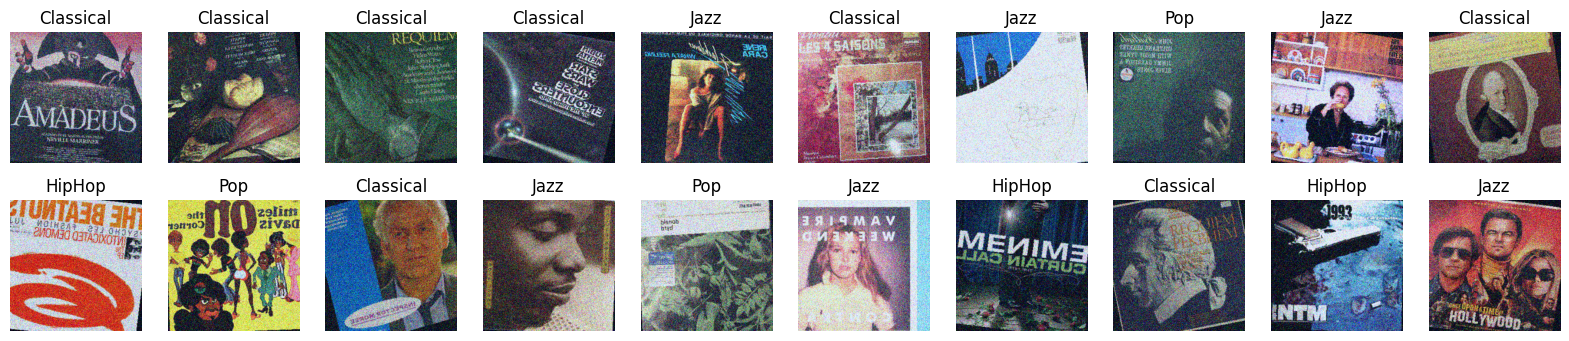

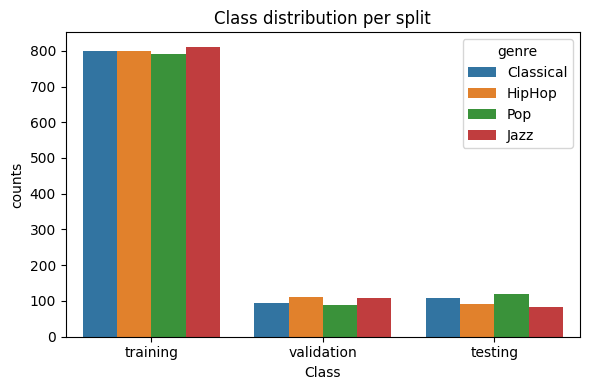

In [8]:
# @title Dataset Visualizations
# @markdown Here, we visualize some sample inputs from the training dataset as well as their associated genres.
# @markdown Additionally, we also visualize the distributions of each genre accross the training/validaiton/testing datasets.
# @markdown Using that information, we can ensure that we have an even and representative split of each genre.

# 1. Plot some sample images from the training set
nrow = 2 # @param {type:"integer"}
ncol = 10 # @param {type:"integer"}

sample_inputs, sample_labels = next(iter(training_dataloader))
for _ in range(5):
  next(iter(training_dataloader))
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(2 * ncol, 2 * nrow))

axes = axes.flatten()
for i in range(nrow * ncol):
    img = sample_inputs[i]
    label = sample_labels[i]
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide the axis
        axes[i].set_title(classes_to_keep[int(label)])
    else:
        print(f"Image {i} is not a 3-channel RGB image.")

fig = plt.gcf()
figures.append(("sample_inputs", fig))



# 2. Plot distributions
labels = [label for _, label in training_dataset]
training_labels, training_counts = np.unique(labels, return_counts=True)

labels = [label for _, label in validation_dataset]
validation_labels, validation_counts = np.unique(labels, return_counts=True)

labels = [label for _, label in testing_dataset]
testing_labels, testing_counts = np.unique(labels, return_counts=True)

df = pd.DataFrame(columns=['set', 'genre', 'counts'])

set_info = [
    ("training", training_labels, training_counts),
    ("validation", validation_labels, validation_counts),
    ("testing", testing_labels, testing_counts),
]

for i in range(len(classes)):
  for j in range(3):
    df.loc[len(df)] = [ set_info[j][0], classes[i], set_info[j][2][i] ]

plt.figure(figsize=(6, 4))
ax = sns.barplot(y='counts', x='set', hue='genre', data=df)
ax.set_title("Class distribution per split")
ax.set_xlabel("Class")

fig = plt.gcf()
figures.append(("class_distributions", fig))


plt.tight_layout()
plt.show()

In [ ]:
# @title Model and hyperparameter setup
CLASSIFIER_LR = 1e-4
CLASSIFIER_WEIGHT_DECAY = 0.0005
CLASSIFIER_MAX_EPOCHS = 100
CLASSIFIER_MIN_VAL_DELTA = 0.001
CLASSIFIER_PATIENCE = 5

weights = torchvision.models.convnext.ConvNeXt_Base_Weights.IMAGENET1K_V1
convnext_base = torchvision.models.convnext_base(weights=weights)
convnext_base.classifier[2] = nn.Linear(in_features=1024, out_features=len(classes), bias=True)

model = convnext_base
model = model.to(DEVICE)
sample_inputs, _ = next(iter(training_dataloader))
_ = summary(model, sample_inputs)
print(f"Input Shape: {sample_inputs.shape}")

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CLASSIFIER_LR, weight_decay=CLASSIFIER_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [ ]:
# @title Training and Evaluation
best_val_loss = float("inf")
best_val_loss_epoch = 0
epochs_no_improve = 0
best_model = copy.deepcopy(model)

training_epoch_losses = []
validation_epoch_losses = []

training_batch_losses = []
validation_batch_losses = []

for epoch in range(CLASSIFIER_MAX_EPOCHS):
    # a- training loop
    training_running_loss = 0.0
    _training_batch_losses = []

    for current_batch, (inputs, labels) in enumerate(training_dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()

        training_running_loss += l.item() * inputs.shape[0]
        _training_batch_losses.append(l.item())

    training_epoch_loss = training_running_loss / len(training_dataset)
    training_epoch_losses.append(training_epoch_loss)
    training_batch_losses.append(_training_batch_losses)
    print(f"[Epoch {epoch + 1}] Finished training with loss {training_epoch_loss}")


    # b- validation loop
    validation_running_loss = 0.0
    _validation_batch_losses = []
    with torch.no_grad():
        for current_batch, (inputs, labels) in enumerate(validation_dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            output = model(inputs)
            l = loss(output, labels)

            validation_running_loss += l.item() * inputs.shape[0]
            _validation_batch_losses.append(l.item())

    validation_epoch_loss = validation_running_loss / len(validation_dataset)
    validation_epoch_losses.append(validation_epoch_loss)
    validation_batch_losses.append(_validation_batch_losses)
    print(f"[Epoch {epoch + 1}] [VALIDATION] Finished training with loss {validation_epoch_loss}")
    # scheduler.step(validation_epoch_loss)


    # c- interpret validation results, stop if overfitting detected
    if validation_epoch_loss < best_val_loss - CLASSIFIER_MIN_VAL_DELTA:
        best_val_loss = validation_epoch_loss
        best_val_loss_epoch = i + 1
        epochs_no_improve = 0
        best_model = copy.deepcopy(model)
        print(f"New best validation loss at epoch {epoch + 1}: {best_val_loss}")
    else:
        if epochs_no_improve is None:
            epochs_no_improve = 0
        epochs_no_improve += 1

    if epochs_no_improve >= CLASSIFIER_PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        break

In [6]:
model = copy.deepcopy(best_model)
model.eval()
correct = 0
total = 0

confusion_matrix = np.zeros((len(classes), len(classes))).astype(np.int32)

with torch.no_grad():
    for images, labels in testing_dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        pred_labels = torch.argmax(outputs, dim=1)

        for i in range(pred_labels.shape[0]):
            confusion_matrix[labels[i], pred_labels[i]] += 1

## Visualizations

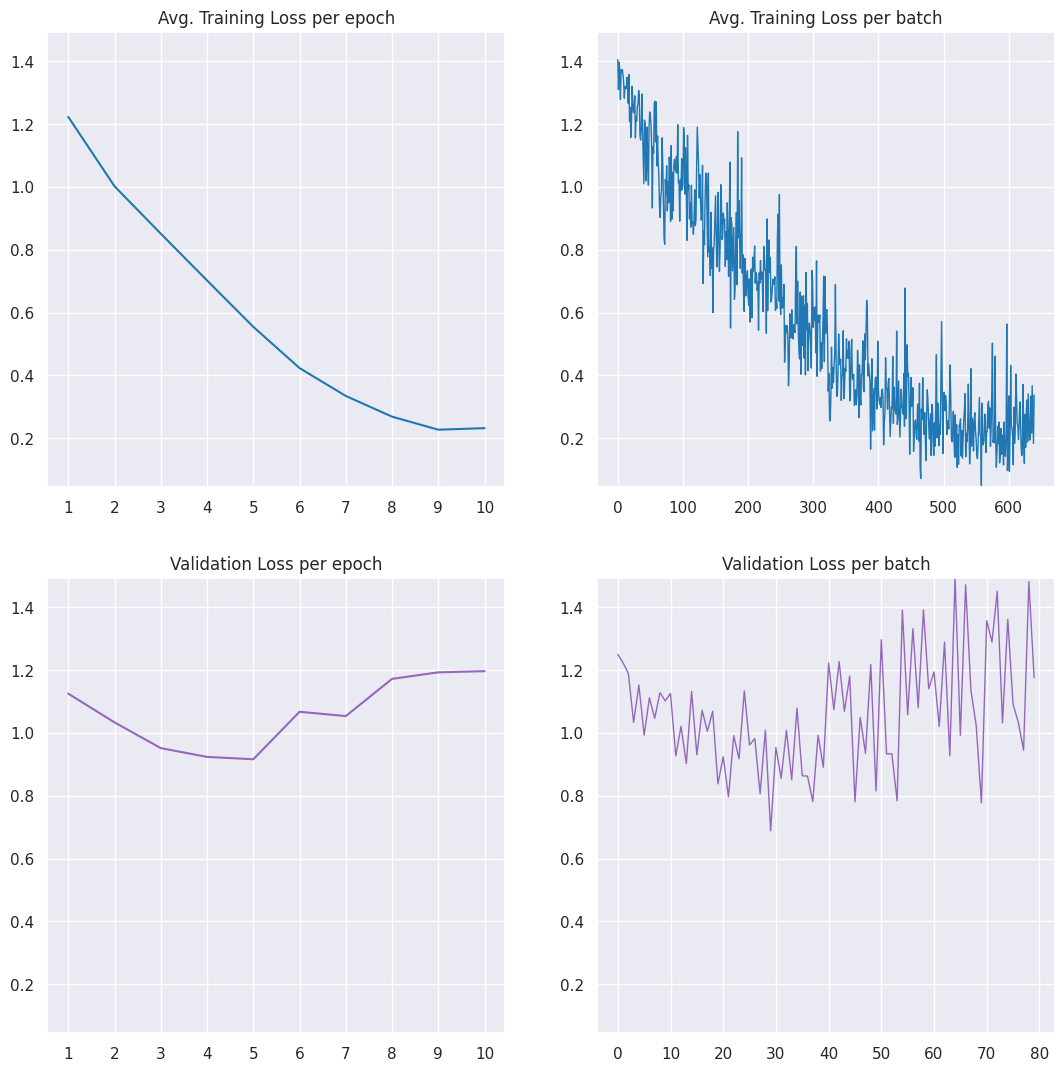

In [7]:
# @title Plot Training and Validation Losses
import itertools

# processing 'batch_losses'
training_batch_lengths = [len(sublist) for sublist in training_batch_losses]
training_cumulative_counts = list(itertools.accumulate(training_batch_lengths))[:-1]
training_cumulative_counts.insert(0, 0)
training_batch_losses_flattened = list(itertools.chain.from_iterable(training_batch_losses))

validation_batch_lengths = [len(sublist) for sublist in validation_batch_losses]
validation_cumulative_counts = list(itertools.accumulate(validation_batch_lengths))[:-1]
validation_cumulative_counts.insert(0, 0)
validation_batch_losses_flattened = list(itertools.chain.from_iterable(validation_batch_losses))

max_loss = max(np.max(training_batch_losses_flattened), np.max(training_epoch_losses), np.max(validation_batch_losses_flattened), np.max(validation_epoch_losses))
min_loss = min(np.min(training_batch_losses_flattened), np.min(training_epoch_losses), np.min(validation_batch_losses_flattened), np.min(validation_epoch_losses))
ylim_bottom_scale = 1 * 0.9


# actual plotting
# 1. Plotting training losses
sns.set_theme()
plt.figure(figsize=(13, 13))

plt.subplot(2, 2, 1)
x = np.linspace(1, len(training_epoch_losses), len(training_epoch_losses))
ax = sns.lineplot(x=x, y=training_epoch_losses, color="tab:blue", linewidth=1.5, markers=True)
ax.set_title("Avg. Training Loss per epoch")
plt.xticks(ticks=x)
plt.ylim(bottom=min_loss * ylim_bottom_scale, top=max_loss)


plt.subplot(2, 2, 2)
x = np.arange(len(training_batch_losses_flattened))
ax = sns.lineplot(x=x, y=training_batch_losses_flattened, color="tab:blue", linewidth=1, markers=True)
ax.set_title("Avg. Training Loss per batch")
plt.ylim(bottom=min_loss * ylim_bottom_scale, top=max_loss)

line = ax.lines[0]
color = line.get_color()


# 2. Plotting validation loss
plt.subplot(2, 2, 3)
x = np.linspace(1, len(validation_epoch_losses), len(validation_epoch_losses))
ax = sns.lineplot(x=x, y=validation_epoch_losses, color="tab:purple", linewidth=1.5, markers=True)
ax.set_title("Validation Loss per epoch")
plt.xticks(ticks=x)
plt.ylim(bottom=min_loss * ylim_bottom_scale, top=max_loss)


plt.subplot(2, 2, 4)
x = np.arange(len(validation_batch_losses_flattened))
ax = sns.lineplot(x=x, y=validation_batch_losses_flattened, color="tab:purple", linewidth=1, markers=True)
ax.set_title("Validation Loss per batch")
plt.ylim(bottom=min_loss * ylim_bottom_scale, top=max_loss)

line = ax.lines[0]
color = line.get_color()


fig = plt.gcf()
figures.append(("training_loss", fig))

plt.show()

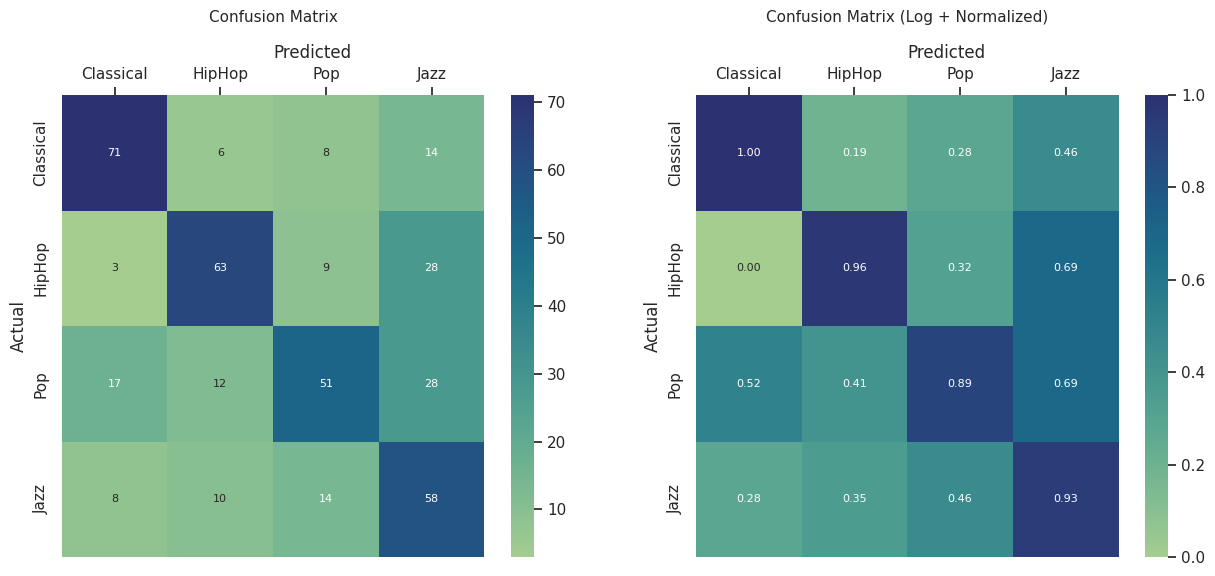

In [8]:
# @title Plot Confusion Matrix on testing set
# @markdown Note that we also plot a log + normalized version of the confusion matrix on the right.
# @markdown This make 'hotspots' more visible.
def normalize(x): return (x - x.min()) / (x.max() - x.min())

plt.figure(figsize=(15, 6))
column_label_y = 1.08
plt.subplot(1, 2, 1)
ax = sns.heatmap(confusion_matrix, annot=True, cmap='crest', fmt=".0f", annot_kws={"fontsize": 8}, xticklabels=classes_to_keep, yticklabels=classes_to_keep)
ax.xaxis.tick_top()
ax.set_title('Confusion Matrix', fontsize=11, y=1.14)
ax.text(0.5, column_label_y, "Predicted", transform=ax.transAxes)
ax.set_ylabel("Actual")


plt.subplot(1, 2, 2)
ax = sns.heatmap(normalize(np.log(confusion_matrix + 1)), annot=True, cmap='crest', fmt=".2f", annot_kws={"fontsize": 8}, xticklabels=classes_to_keep, yticklabels=classes_to_keep)
ax.xaxis.tick_top()
ax.set_title('Confusion Matrix (Log + Normalized)', fontsize=11, y=1.14)
ax.text(0.5, column_label_y, "Predicted", transform=ax.transAxes)
ax.set_ylabel("Actual")

fig = plt.gcf()
figures.append(("test_confusion_matrix", fig))

plt.show()

In [9]:
# @title Construct Performance Metrics Matrix
performance_metrics = pd.DataFrame(columns=["recall", "precision", "f1-score"])

for i in range(confusion_matrix.shape[0]):
    row = confusion_matrix[i, :].astype(np.int32)
    col = confusion_matrix[:, i].astype(np.int32)

    np_sum = np.sum(row)
    recall = 0
    precision = 0
    if np_sum != 0:
        recall = row[i] / np_sum
        precision = col[i] / np_sum

    f1 = 0
    if recall != 0 or precision != 0:
        f1 =  (2 * recall * precision) / (recall + precision)

    performance_metrics.loc[i] = [recall, precision, f1]

overall_accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
print(f"Overall accuracy: {overall_accuracy}")

performance_metrics

Overall accuracy: 0.6075


recall  precision  f1-score
0  0.717172   0.717172  0.717172
1  0.611650   0.611650  0.611650
2  0.472222   0.472222  0.472222
3  0.644444   0.644444  0.644444

In [ ]:
# Save weights
classifier_save_dir = os.path.join(DEFAULT_SAVE_PATH, "classifier")
if not os.path.exists(classifier_save_dir):
    os.makedirs(classifier_save_dir)

torch.save(model.state_dict(), os.path.join(classifier_save_dir, "classifier.pth"))

if SAVE_TO_DRIVE:
  dst = f"{DRIVE_MOUNT_PATH}/MyDrive{DRIVE_SAVE_PATH}"
  shutil.copytree(RUNS_DIR, dst, dirs_exist_ok=True)

# Music Snippet VAEs
We train a VAE for each of our genres.
From experimentation, I've observed a singular VAE trained on the whole dataset was unable to generalize a probability distribution per genre.
For more information, see the report.

### Dataset
We use the [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset from Kaggle.
Similar to the classifier, we only use 4 genres from the dataset: `Classical`, `HipHop`, `Pop`, and `Electronic`.
We keep the audio as waveforms, cut each to be 15 seconds long at a sampling rate of 22.05kHz.
Since we're working with VAEs, no dataset augmentations are performed.


****
### Model and Hyperparameters
We are using a simple VAE inspired from InstructME without any pre-trained weights.
The dataset is split with a training/testing split of ratios 0.8/0.2 respectively.
We are using a batch size of 1, and the model is trained end-to-end with Adam using mean squared error (MSE) loss with a learning rate of 𝛼 = 0.0002

****
### Evaluation Metrics
Our primary objective evaluation metric is the Frechet Audio Distance (FAD).
FAD is a measure of how close generated audio is compared to real audio by comparing their latent space representations from a pre-trained model.
In other words, it is a measure of how well the generated audio fits into the distribution of the real audio.


In [42]:
# @title Dataset Setup
import librosa
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

SR = 22_050

def load_audio_files(files, sr=SR):
    """
    Load multiple audio files at a given sampling rate.

    Args:
        files (list[str]): Paths to audio files to load.
        sr (int): Target sampling rate for all audio files.

    Returns:
        list[np.ndarray]: List of 1D numpy arrays containing audio samples.
                          Skips files that fail to load, printing a warning.
    """
    audio_data = []
    for file in files:
        try:
            data, _ = librosa.load(file, sr=sr)
            audio_data.append(data)
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")
    return audio_data


def pad_audio_data(audio_data, target_length):
    """
    Pad or truncate audio clips to a fixed length.

    Args:
        audio_data (list[np.ndarray]): List of 1D audio sample arrays.
        target_length (int): Desired length in samples for each clip.

    Returns:
        np.ndarray: 2D array of shape (N, target_length), where N is the
                    number of clips. Clips shorter than target_length are
                    zero-padded; longer clips are truncated.
    """
    padded_audio_data = []
    for clip in audio_data:
        if len(clip) < target_length:
            pad_length = target_length - len(clip)
            padded_clip = np.pad(clip, (0, pad_length), mode='constant')
        else:
            padded_clip = clip[:target_length]
        padded_audio_data.append(padded_clip)
    return np.array(padded_audio_data)


def get_split_dataloaders(padded_audio_data, test_size=0.2, random_state=42):
    """
    Split audio data into training and testing loaders with normalization.

    Args:
        padded_audio_data (np.ndarray): 2D array of shape (N, L) with padded audio.
        test_size (float): Proportion of data to reserve for testing.
        random_state (int): Seed for reproducible splits.

    Returns:
        tuple[DataLoader, DataLoader]: Train and test DataLoader objects with batch_size=8.
    """
    # split
    train_data, test_data = train_test_split(
        padded_audio_data,
        test_size=test_size,
        random_state=random_state
    )

    # normalize
    max_val = max(np.abs(train_data).max(), np.abs(test_data).max())
    train_norm = train_data / max_val
    test_norm = test_data / max_val

    # to tensors
    train_tensor = torch.tensor(train_norm, dtype=torch.float32).unsqueeze(1)
    test_tensor = torch.tensor(test_norm, dtype=torch.float32).unsqueeze(1)

    # datasets & loaders
    train_ds = TensorDataset(train_tensor)
    test_ds = TensorDataset(test_tensor)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

    return train_loader, test_loader



path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
path = f"{path}/Data/genres_original/"
print("Path to dataset files:", path)

files_per_genre = [list((pathlib.Path(path) / genre.lower()).glob('*.wav')) for genre in classes]
audio_per_genre = [load_audio_files(files) for files in files_per_genre]
flattened = [item for sublist in audio_per_genre for item in sublist]
target_length = min(map(len, flattened)) // 2
audio_per_genre_padded = [pad_audio_data(audio_data, target_length) for audio_data in audio_per_genre]

loaders_per_genre = [get_split_dataloaders(padded_audio) for padded_audio in audio_per_genre_padded]
genre_loader_pairs = list(zip(classes, loaders_per_genre))

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/


<ipython-input-42-432fcaa6588b>:23: UserWarning: PySoundFile failed. Trying audioread instead.
  data, _ = librosa.load(file, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping file /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav due to error: 


## Dataset Visualizations

In [43]:
for genre, (train_loader, _) in genre_loader_pairs:
  sample = next(iter(train_loader))[0][0][0].numpy()
  print(f"Sample audio from `{genre}`")
  display.display(display.Audio(sample, rate=SR))

Sample audio from `Classical`


Sample audio from `HipHop`


Sample audio from `Pop`


Sample audio from `Jazz`


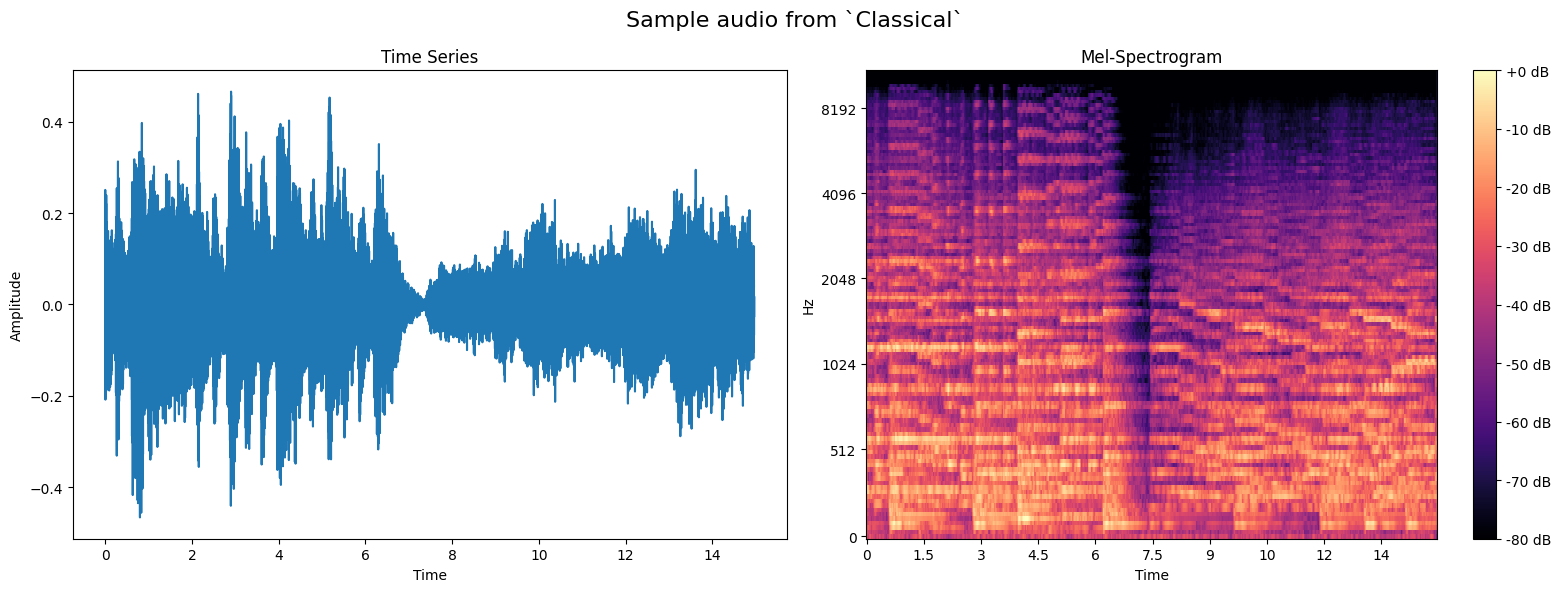

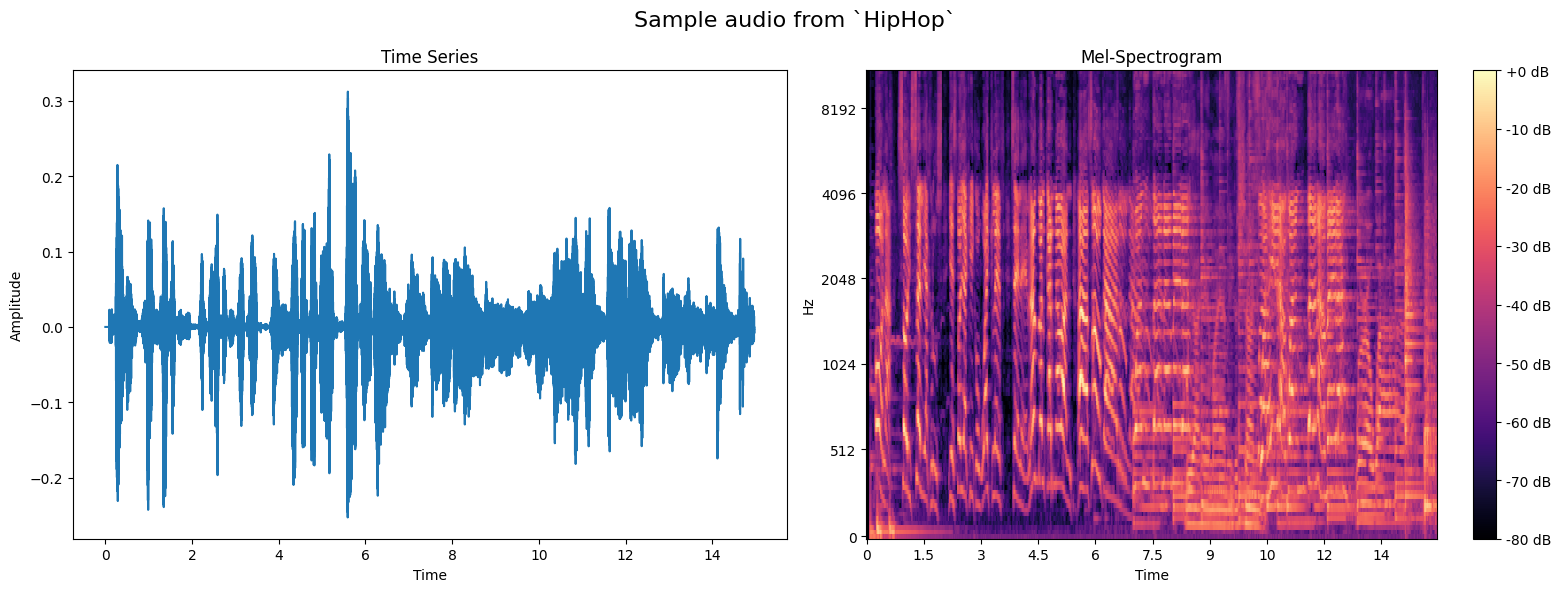

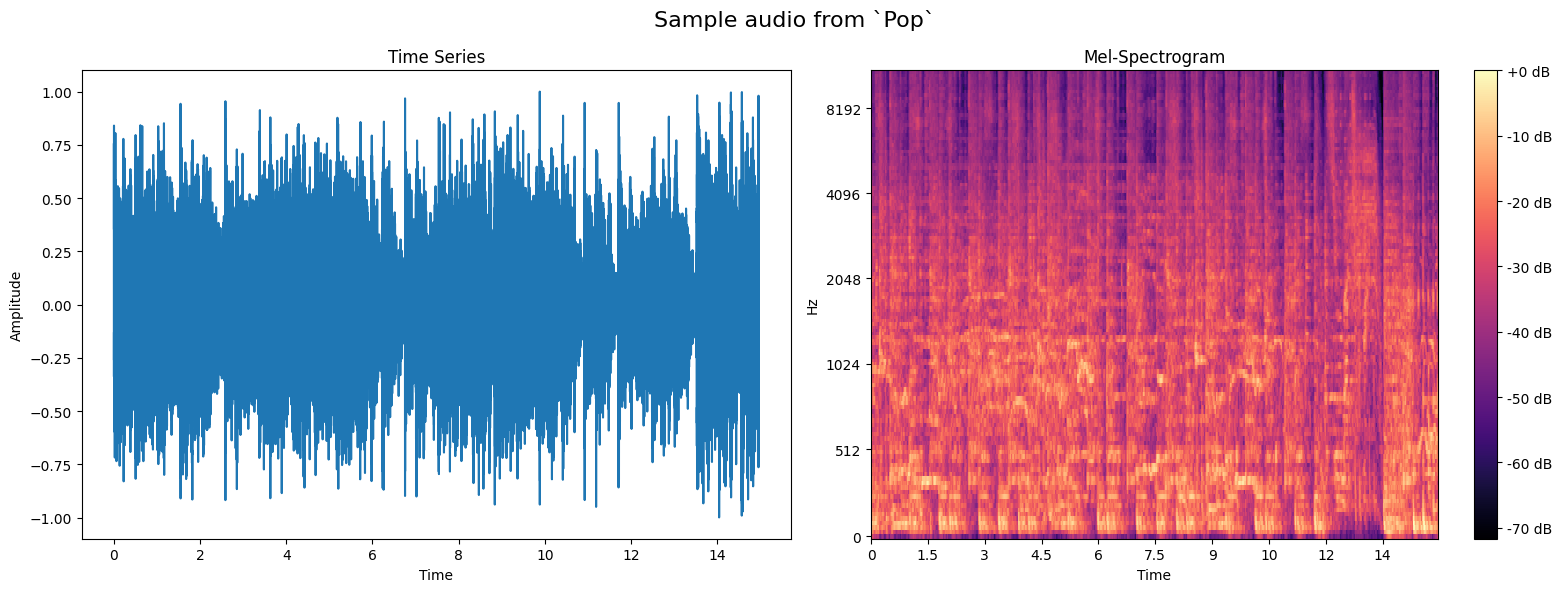

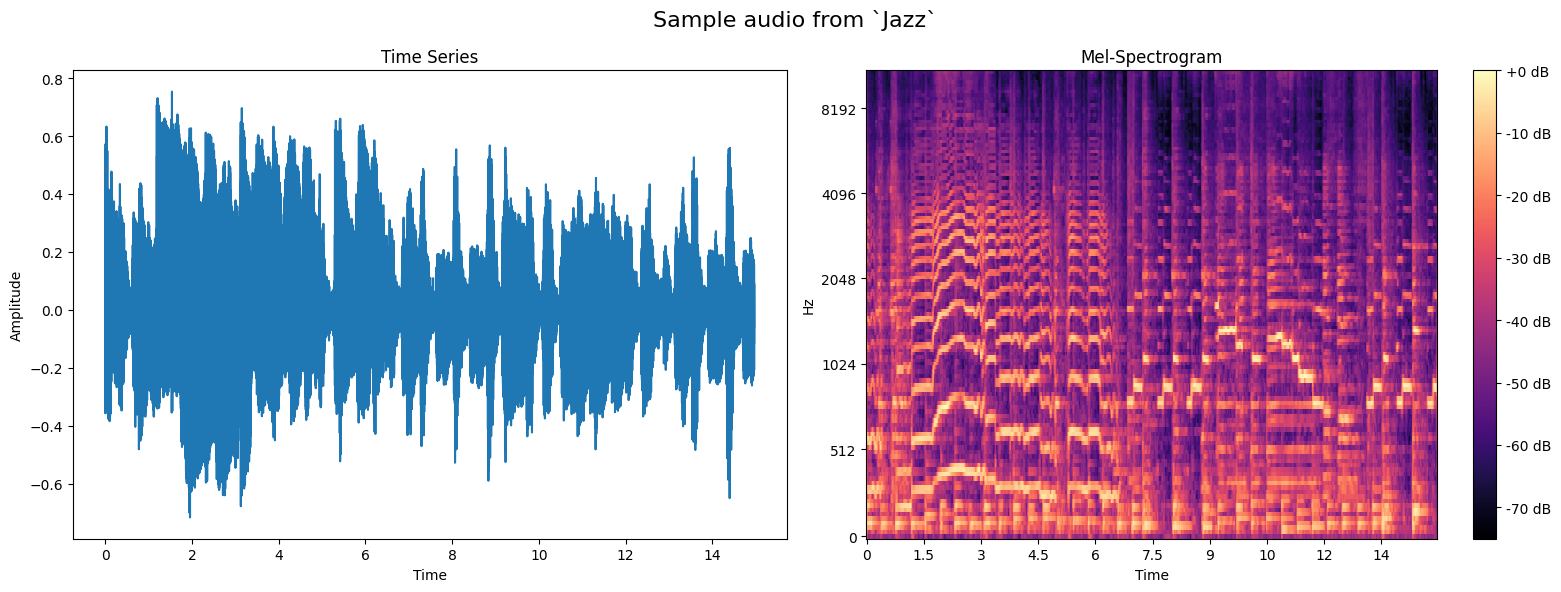

In [44]:
for genre, (train_loader, _) in genre_loader_pairs:
    sample = next(iter(train_loader))[0][0][0].numpy()

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Sample audio from `{genre}`", fontsize=16)

    # Left: waveform
    times = np.linspace(0, len(sample) / SR, num=len(sample))
    ax[0].plot(times, sample)
    ax[0].set_title('Time Series')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')

    # Right: mel-spectrogram
    mel = librosa.feature.melspectrogram(y=sample, sr=SR)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    img = librosa.display.specshow(mel_db, sr=SR, x_axis='time', y_axis='mel', ax=ax[1])
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
    ax[1].set_title("Mel-Spectrogram")

    plt.tight_layout()
    plt.show()

## Model and Hyperparameters Setup

In [45]:
class AutoEncoder(nn.Module):
    """
    Convolutional AutoEncoder for 1D signals.
    In the context of this project, it acts as a Variational AutoEncoder (VAE) for audio waveforms.

    Original Author:
    https://yuehan-z.medium.com/introduction-to-vaes-in-ai-music-generation-d8e0cfc2245b

    Args:
        in_channels (int): Number of channels in the input tensor.
        out_channels (int): Number of channels in the output tensor.
        down_channels (list[int]): Output channels for each encoder block.
        up_channels (list[int]): Output channels for each decoder block.
        down_rate (list[int]): Stride values for each encoder convolution.
        up_rate (list[float]): Upsampling factors for each decoder stage.
        cross_attention_dim (int): Number of channels in the bottleneck layers.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        down_channels,
        up_channels,
        down_rate,
        up_rate,
        cross_attention_dim
    ):
        """
        Initialize encoder, bottleneck, decoder, and output layers.
        """
        super(AutoEncoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.down_channels = down_channels
        self.up_channels = up_channels
        self.down_rate = down_rate
        self.up_rate = up_rate
        self.cross_attention_dim = cross_attention_dim

        # build encoder
        self.encoder_layers = nn.ModuleList()
        for i, out_ch in enumerate(down_channels):
            in_ch = in_channels if i == 0 else down_channels[i-1]
            stride = down_rate[i]
            layer = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True)
            )
            self.encoder_layers.append(layer)

        # build bottleneck
        self.bottleneck_layers = nn.Sequential(
            nn.Conv1d(down_channels[-1], cross_attention_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(cross_attention_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(cross_attention_dim, cross_attention_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(cross_attention_dim),
            nn.ReLU(inplace=True)
        )

        # build decoder
        self.decoder_layers = nn.ModuleList()
        for i, out_ch in enumerate(up_channels):
            in_ch = cross_attention_dim if i == 0 else up_channels[i-1]
            layer = nn.Sequential(
                nn.ConvTranspose1d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True),
                nn.ConvTranspose1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(out_ch),
                nn.ReLU(inplace=True)
            )
            self.decoder_layers.append(layer)

        # final output
        self.output_layer = nn.Sequential(
            nn.ConvTranspose1d(up_channels[-1], out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the autoencoder.

        Args:
            x (Tensor): Input tensor of shape (B, in_channels, L).

        Returns:
            Tensor: Reconstructed tensor of shape (B, out_channels, 330000).
        """
        x = self.encode(x)
        x = self.bottleneck(x)
        x = self.decode(x)
        x_out = self.output_layer(x)
        # trim or pad to fixed length
        x_out = x_out[:, :, :330_000]
        return x_out

    def encode(self, x):
        """
        Apply encoder layers to downsample input.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Latent representation.
        """
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def bottleneck(self, x):
        """
        Process latent tensor through bottleneck convolutional blocks.

        Args:
            x (Tensor): Encoder output tensor.

        Returns:
            Tensor: Features at bottleneck.
        """
        return self.bottleneck_layers(x)

    def decode(self, x):
        """
        Apply decoder layers with upsampling to reconstruct features.

        Args:
            x (Tensor): Bottleneck feature tensor.

        Returns:
            Tensor: Upsampled feature tensor before output.
        """
        for i, layer in enumerate(self.decoder_layers):
            target_length = int(x.shape[2] * self.up_rate[i])
            x = nn.functional.interpolate(x, size=target_length, mode='nearest')
            x = layer(x)
        return x

# AutoEncoder class with the provided configuration.
model_config_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'down_channels': [16, 32, 64, 128],
    'up_channels': [384, 192, 96, 48],
    'down_rate': [4, 4, 3 ,2],
    'up_rate': [2, 3 ,4 ,4],
    'cross_attention_dim': 1024,
}

## Training and Evaluation

In [47]:
training_results = []

for genre, (train_loader, test_loader) in genre_loader_pairs:
    epochs = 500
    epochs = 2
    print(f"[{genre}] Epochs: {epochs}")

    model = AutoEncoder(**model_config_dict)
    model = model.to(DEVICE)
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    for epoch in range(epochs):
        for idx, input in enumerate(train_loader):
            input = input[0].to(DEVICE)
            x_recon = model(input)
            L_rec = mse_loss(x_recon, input)
            L_vae = L_rec
            L_vae.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {L_vae.item()}")


    # save training data
    training_result = {
        "genre": genre,
        "model": model,
        "train_loader": train_loader,
        "test_loader": test_loader
    }
    training_results.append(training_result)


    # save model parameters as files
    vae_save_dir = os.path.join(DEFAULT_SAVE_PATH, "vae", genre)
    if not os.path.exists(vae_save_dir):
        os.makedirs(vae_save_dir)

    torch.save(model.state_dict(), os.path.join(vae_save_dir, "model.pth"))

    if SAVE_TO_DRIVE:
      dst = f"{DRIVE_MOUNT_PATH}/MyDrive{DRIVE_SAVE_PATH}"
      shutil.copytree(RUNS_DIR, dst, dirs_exist_ok=True)

[Classical] Epochs: 2
Epoch 1, Loss: 0.06712565571069717
Epoch 2, Loss: 0.011838935315608978
[HipHop] Epochs: 2
Epoch 1, Loss: 0.11516014486551285
Epoch 2, Loss: 0.08538451045751572
[Pop] Epochs: 2
Epoch 1, Loss: 0.06950964778661728
Epoch 2, Loss: 0.048968181014060974
[Jazz] Epochs: 2
Epoch 1, Loss: 0.09066969901323318
Epoch 2, Loss: 0.07209031283855438


In [48]:
# @title Import VGGish Repo & Weights to Perform FAD
!pip install tensorflow scipy
!pip install resampy
!pip install soundfile

!git clone https://github.com/tensorflow/models.git
!mv models/research/audioset/vggish ./
!rm -rf models

os.makedirs("/content/vggish/", exist_ok=True)
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt
!gdown 1cxWq874GMY0-Fb-dLVOiVn8zNknHBiTc --output "/content/vggish/"
!gdown 1-9RjQlp8e4p9sejV7J_Sfin6fVhET7Ue --output "/content/vggish/"
!gdown 1AUZ_TZ8ZD_-LmmGXAWR8NKG4rjrHd-12 --output "/content/vggish/"
!gdown 1C1e2nuEQ05CQeWHrson4fFt6GCSlOk98 --output "/content/vggish/"

Cloning into 'models'...
remote: Enumerating objects: 99739, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 99739 (delta 58), reused 40 (delta 40), pack-reused 99656 (from 4)
Receiving objects: 100% (99739/99739), 626.61 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (72587/72587), done.
mv: cannot move 'models/research/audioset/vggish' to './vggish': Directory not empty
--2025-04-20 19:42:55--  https://storage.googleapis.com/audioset/vggish_model.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291108469 (278M) [application/octet-stream]
Saving to: ‘vggish_model.ckpt.4’

vggish_model.ckpt.4 100%[===================>] 277.62M  23.4MB/s    in 13s     

2025-04-20 19:43:09 (20.9 MB/s) - ‘vggish_model.ckpt

In [49]:
import sys
sys.path.append('./vggish')

import numpy as np
import tensorflow as tf
from vggish_input import waveform_to_examples
from vggish_slim import define_vggish_slim, load_vggish_slim_checkpoint

from scipy.linalg import sqrtm

def get_embeddings(wavs, sr=22_050):
    """
    Compute VGGish embeddings for a list of raw audio waveforms.

    Args:
        wavs (list[np.ndarray]): Audio waveforms as 1D arrays.
        sr (int): Sampling rate of the input waveforms.

    Returns:
        np.ndarray: 2D array of shape (N, D) where N is total examples
                    and D is the embedding dimension.
    """
    # prepare input features for VGGish
    examples = [waveform_to_examples(wav, sr) for wav in wavs]
    examples = np.vstack(examples)

    # run VGGish in a fresh TF graph/session
    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
        define_vggish_slim()
        load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')
        features_tensor = sess.graph.get_tensor_by_name('vggish/input_features:0')
        embedding_tensor = sess.graph.get_tensor_by_name('vggish/embedding:0')
        embeddings = sess.run(embedding_tensor,
                              feed_dict={features_tensor: examples})
    return embeddings

def frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Calculate the Fréchet distance (a.k.a. FID) between two Gaussian distributions.

    Args:
        mu1 (np.ndarray): Mean vector of the first distribution.
        sigma1 (np.ndarray): Covariance matrix of the first distribution.
        mu2 (np.ndarray): Mean vector of the second distribution.
        sigma2 (np.ndarray): Covariance matrix of the second distribution.

    Returns:
        float: Fréchet distance between the two distributions.
    """
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    # numerical stability: discard imaginary part
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_fad(wavs_real, wavs_gen, sr=22_050):
    """
    Compute the Fréchet Audio Distance (FAD) between real and generated audio sets.

    This metric uses VGGish embeddings and the Fréchet distance.

    Args:
        wavs_real (list[np.ndarray]): List of real audio waveforms.
        wavs_gen (list[np.ndarray]): List of generated audio waveforms.
        sr (int): Sampling rate of the audio waveforms.

    Returns:
        float: Fréchet Audio Distance between the two sets.
    """
    emb_r = get_embeddings(wavs_real, sr)
    emb_g = get_embeddings(wavs_gen, sr)
    mu_r, sigma_r = emb_r.mean(axis=0), np.cov(emb_r, rowvar=False)
    mu_g, sigma_g = emb_g.mean(axis=0), np.cov(emb_g, rowvar=False)
    return frechet_distance(mu_r, sigma_r, mu_g, sigma_g)


In [50]:
for result in training_results:
    genre = result["genre"]
    model = result["model"]
    train_loader = result["train_loader"]
    test_loader = result["test_loader"]

    # model.load_state_dict(torch.load(f"/content/vggish/{genre.lower()}.pth"))
    inputs = []
    recons = []
    model.eval()
    with torch.no_grad():
        for idx, input in enumerate(test_loader):
            input = input[0].to(DEVICE)
            recon = model(input)

            inputs.extend(input.detach().cpu().numpy().squeeze(1).tolist())
            recons.extend(recon.detach().cpu().numpy().squeeze(1).tolist())

    fad_scores = []

    for _input, _recon in zip(inputs, recons):
        _input = np.array(_input)
        _recon = np.array(_recon)
        score = compute_fad([_input], [_recon])
        fad_scores.append(score)

    mean_fad = np.sum(np.array(fad_scores))
    print(f"Mean FAD for \"{genre}\": {mean_fad}")


/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


Mean FAD for "Classical": 465.8884978731373
Mean FAD for "HipHop": 687.2180967956098
Mean FAD for "Pop": 603.2818148169418
Mean FAD for "Jazz": 641.8638888370764
